<a href="https://colab.research.google.com/github/nee1k/ab_testing/blob/main/Social_Media_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading & Exploring Data

In [20]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/User_Data.csv")
df

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00
...,...,...,...,...
19995,19996,1,con,NaN
19996,19997,1,con,NaN
19997,19998,1,con,NaN
19998,19999,0,con,NaN


In [21]:
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


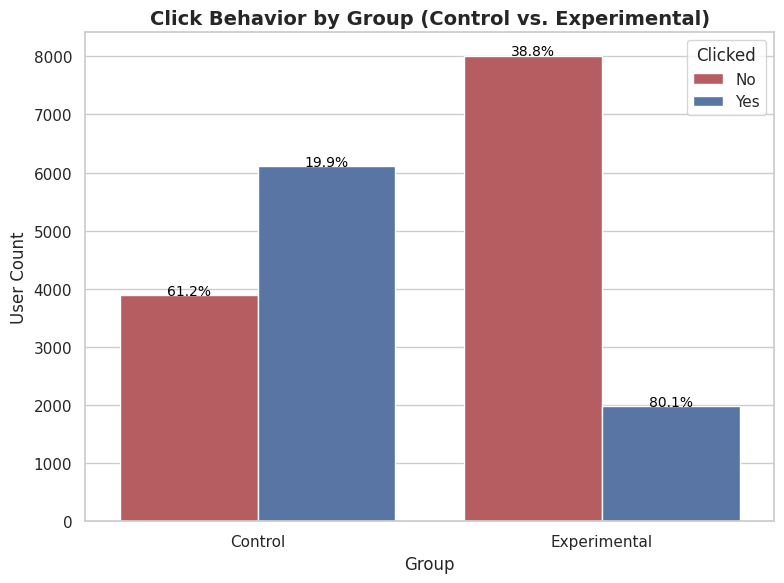

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set(style='whitegrid')

# Create figure and axis
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=df,
    x='group',
    hue='click',
    palette={0: '#C44E52', 1: '#4C72B0'}
)

# Set titles and labels
plt.title('Click Behavior by Group (Control vs. Experimental)', fontsize=14, weight='bold')
plt.xlabel('Group', fontsize=12)
plt.ylabel('User Count', fontsize=12)
plt.xticks([0, 1], ['Control', 'Experimental'])
plt.legend(title='Clicked', labels=['No', 'Yes'])

# Add gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Compute total counts per group for percentage calculations
total_counts = df.groupby('group')['user_id'].count()

# Annotate bars with percentages
group_labels = df['group'].unique()
click_labels = df['click'].unique()

bar_index = 0
for group in group_labels:
    group_df = df[df['group'] == group]
    group_total = len(group_df)

    for click_val in click_labels:
        count = len(group_df[group_df['click'] == click_val])
        percentage = (count / group_total) * 100 if group_total > 0 else 0

        bar = ax.patches[bar_index]
        ax.annotate(f"{percentage:.1f}%",
                    (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2),
                    ha='center', fontsize=10, color='black')
        bar_index += 1

plt.tight_layout()
plt.show()


## 2. Setting Parameters & Calculating Group Statistics

### **Significance Level (α)**
The significance level (α) is the probability of rejecting the null hypothesis when it is actually true (Type I error). It represents the risk we are willing to take of making a false positive conclusion.

### **Minimum Detectable Effect (δ)**
The Minimum Detectable Effect (MDE) is the smallest effect size that we want to be able to detect with our hypothesis test. It represents the practical significance of the difference between the groups. Setting an MDE helps us to determine the required sample size to achieve the desired power.


In [23]:
# Set and display significance level and minimum detectable effect
alpha = 0.05
delta = 0.1

print("Significance level (α):", alpha)
print("Minimum detectable effect (δ):", delta)

Significance level (α): 0.05
Minimum detectable effect (δ): 0.1


In [24]:
# Calculate and display group statistics: number of users and total clicks
N_control = df[df["group"] == "con"]["user_id"].count()
N_experimental = df[df["group"] == "exp"]["user_id"].count()

X_control = df.groupby("group")["click"].sum().loc["con"]
X_experimental = df.groupby("group")["click"].sum().loc["exp"]

print("Number of users in control group:", N_control)
print("Number of users in experimental group:", N_experimental)
print("Total clicks in control group:", X_control)
print("Total clicks in experimental group:", X_experimental)

Number of users in control group: 10000
Number of users in experimental group: 10000
Total clicks in control group: 1989
Total clicks in experimental group: 6116


## 3. Hypothesis Testing

In hypothesis testing, the null hypothesis (H0) is a statement that assumes there is no significant effect, relationship, or difference between the variables being studied. The alternative hypothesis (H1 or Ha) is a statement that contradicts the null hypothesis, suggesting the presence of a significant effect, relationship, or difference.

* **Null Hypothesis (H0):** There is no significant difference in the effectiveness (e.g., clicks, purchases) between 'average bidding' and 'maximum bidding.'
* **Alternative Hypothesis (H1):** There is a significant difference in the effectiveness (e.g., clicks, purchases) between 'average bidding' and 'maximum bidding.'


### **Statistical Power (1 - Beta)**
Statistical power (1 - beta) is the probability of correctly rejecting the null hypothesis when it is false (i.e., detecting a true effect). It represents the likelihood of finding a statistically significant difference if one truly exists.

Setting **Power (1 - β)** as 0.80 (80%) - This means we want an 80% chance of detecting a significant difference between the bidding strategies if a meaningful difference truly exists.



### **Sample Size**

Calculating the sample size is crucial for ensuring the experiment has enough statistical power to detect a meaningful difference between groups. It involves determining the number of observations needed to achieve the desired significance level, power, and MDE.

**Formula:**
n = 2 * (Zα/2 + Zβ)^2 * (σ^2) / (MDE)^2

where:
* `n` is the sample size per group.
* `Zα/2` is the critical value for the significance level.
* `Zβ` is the critical value for the desired power.
* `σ^2` is the pooled variance.
* `MDE` is the minimum detectable effect.sub

**Example:**
Assuming:
* Significance level (alpha): 0.05
* Power (1 - beta): 0.80

The sample size per group is approximated as:
n = (16 * (σ^2)) / (MDE)^2

In [25]:
# Calculate and display click probability estimates for both groups
con_p_hat = X_control / N_control
exp_p_hat = X_experimental / N_experimental
print("Click probability estimate in control group:", con_p_hat)
print("Click probability estimate in experimental group:", exp_p_hat, end="\n\n")

# Calculate and display pooled click probability and variance estimates
pooled_p_hat = (X_control + X_experimental) / (N_control + N_experimental)
pooled_var_hat = pooled_p_hat * (1-pooled_p_hat) * (1/N_control + 1/N_experimental)
print("Pooled click probability estimate:", pooled_p_hat.round(4))
print("Pooled click variance estimate:", pooled_var_hat.round(4))

Click probability estimate in control group: 0.1989
Click probability estimate in experimental group: 0.6116

Pooled click probability estimate: 0.4052
Pooled click variance estimate: 0.0


In [19]:
import numpy as np
from scipy.stats import norm

# Calculate and display standard error, Z-score, and Z-critical value
standard_error = np.sqrt(pooled_var_hat)
print("Standard error:", standard_error.round(4))

z_statistic = (con_p_hat-exp_p_hat) / standard_error
print("Z-statistic:", z_statistic.round(2))

z_critical = norm.ppf(1 - alpha/2)
print("Z-critical value:", z_critical.round(2))

Standard error: 0.0069
Z-statistic: -59.44
Z-critical value: 1.96


## 4. Checking & Visualizing Statistical Significance

In [26]:
# Define and apply function to check statistical significance
def check_statistical_significance(test_statistic, significance_level):

    p_value = 2 * norm.sf(abs(test_statistic))
    print(f"P-value: {p_value}")

    if p_value <= significance_level:
        print("Statistical significance found! The observed difference between the control and experimental groups is unlikely due to chance.")
    else:
        print("No statistical significance found! The observed difference between the control and experimental groups could be due to chance.")

check_statistical_significance(z_statistic, alpha)

P-value: 0.0
Statistical significance found! The observed difference between the control and experimental groups is unlikely due to chance.


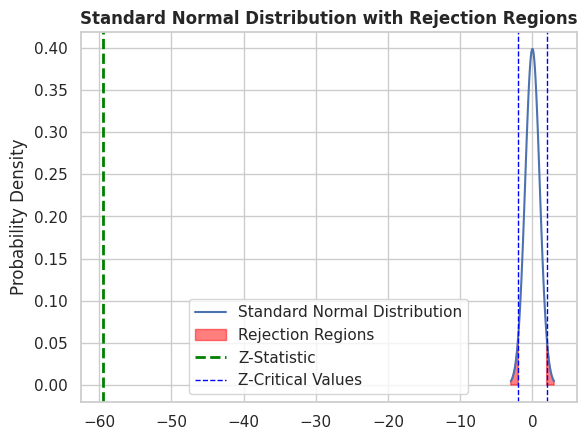

In [27]:
# Define standard normal distribution and calculate x- and y-values
mean = 0
std_dev = 1
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)


# Plot standard normal distribution with rejection regions and Z-test values
plt.plot(x_values, y_values, label='Standard Normal Distribution')
plt.fill_between(x_values, y_values, where=(x_values > z_critical) | (x_values < -z_critical),
                 label='Rejection Regions', color='red', alpha=0.5)

plt.axvline(z_statistic, color='green', linestyle='dashed', linewidth=2, label=f'Z-Statistic')
plt.axvline(z_critical, color='blue', linestyle='dashed', linewidth=1, label=f'Z-Critical Values')
plt.axvline(-z_critical, color='blue', linestyle='dashed', linewidth=1)

plt.title('Standard Normal Distribution with Rejection Regions', weight='bold')
plt.ylabel('Probability Density')

plt.legend()
plt.show()

## 5. Checking Practical Significance

In [28]:
# Calculate and display confidence interval for the two-sample Z-test
confidence_interval = [round((exp_p_hat-con_p_hat) - standard_error*z_critical, 4),
                       round((exp_p_hat-con_p_hat) + standard_error*z_critical, 4)]

print("Confidence interval:", confidence_interval)

Confidence interval: [np.float64(0.3991), np.float64(0.4263)]


In [29]:
# Define and apply function to check practical significance
def check_practical_significance(min_detectable_effect, confidence_interval):

    lower_bound_CI = confidence_interval[0]

    if lower_bound_CI >= min_detectable_effect:
        print("The observed difference between the control and experimental groups is practically significant.")
    else:
        print("The observed difference between the control and experimental groups is not practically significant.")

check_practical_significance(delta, confidence_interval)

The observed difference between the control and experimental groups is practically significant.


---

# **AARRR Metrics Framework for Facebook**

## **Introduction**
The AARRR framework (Acquisition, Activation, Retention, Referral, and Revenue) is a growth model that helps businesses track the user journey from first interaction to monetization. It provides clear insights into how users engage with a product and where optimizations are needed.

---

## **1. Acquisition (How do users find Facebook?)**
Acquisition refers to how users discover and sign up for Facebook.

### **Key Metrics:**
- **New User Signups** – Total number of users who create an account.
- **Signup Conversion Rate** – Percentage of visitors who complete the signup process.
- **Cost per Acquisition (CPA)** – Cost of acquiring a new user through ads or promotions.
- **Traffic Sources** – Breakdown of where new users come from (organic, paid ads, referrals).
- **App Store & Web Page Visits** – Number of users exploring Facebook before signing up.

### **How to Measure:**
- Track traffic sources using **Google Analytics, Meta Pixel, or internal logs**.
- Monitor signup funnel drop-off rates to optimize conversion steps.
- Analyze advertising campaigns' effectiveness and cost.

---

## **2. Activation (How quickly do users get value?)**
Activation measures whether users complete meaningful actions early in their journey.

### **Key Metrics:**
- **Profile Completion Rate** – Percentage of new users who add profile details.
- **Friend Connections within First Week** – Number of accepted friend requests in the first 7 days.
- **First Post or Interaction** – Number of users who post, like, or comment in their first session.
- **Time to First Engagement** – How quickly users perform their first social action.
- **Push Notification Opt-In Rate** – How many users allow notifications to stay engaged.

### **How to Measure:**
- Track **time-to-first-action** through event logs.
- Analyze **onboarding completion** rates and tweak flows to boost engagement.
- Monitor **friend suggestion acceptance rates** to improve connection-building.

---

## **3. Retention (How often do users return?)**
Retention tracks how frequently users return to Facebook over time.

### **Key Metrics:**
- **Daily Active Users (DAU) / Monthly Active Users (MAU)** – Number of users engaging daily/monthly.
- **Churn Rate** – Percentage of users who stop using Facebook after a certain period.
- **Stickiness Ratio (DAU/MAU)** – Measures how frequently users return.
- **Session Frequency & Length** – Number of times users open the app and how long they stay.
- **User Engagement Rate** – Likes, comments, shares, and messages per session.

### **How to Measure:**
- Monitor **cohort retention rates** to see how long users stay active.
- Analyze **push notification and email re-engagement effectiveness**.
- Use **heatmaps and session tracking** to understand drop-off points.

---

## **4. Referral (Do users invite others?)**
Referral measures whether existing users bring new users to Facebook.

### **Key Metrics:**
- **Referral Rate** – Percentage of users who invite others to join Facebook.
- **Virality Coefficient (K-Factor)** – How many additional users a new user invites.
- **Shares per User** – How often users share posts, pages, and invitations.
- **Messenger & WhatsApp Invites** – Number of users invited through Facebook messaging apps.
- **Community & Group Growth** – How many new users join Facebook via groups.

### **How to Measure:**
- Track **invites sent and accepted** from referral programs.
- Measure **click-through rates (CTR) on shared content** leading to signups.
- Conduct **A/B tests** on referral incentives to maximize invites.

---

## **5. Revenue (How does Facebook make money?)**
Revenue tracks how Facebook monetizes its user base.

### **Key Metrics:**
- **Ad Revenue per User (ARPU)** – Average revenue generated per user through ads.
- **Cost per Mille (CPM)** – Revenue earned per thousand ad impressions.
- **Click-Through Rate (CTR) on Ads** – Percentage of users clicking on ads.
- **Ad Impressions per User** – Number of ads displayed per user session.
- **Subscription Revenue (if applicable)** – Earnings from Facebook Blue or other premium features.

### **How to Measure:**
- Use **Facebook Ads Manager** to track ad spend, impressions, and conversions.
- Conduct **A/B tests on ad placements** to optimize revenue per session.
- Analyze **user behavior trends** to adjust monetization strategies without reducing engagement.

---

# **Defining Metrics for Facebook’s Bidding System Analysis**

## **North Star and Guardrail Metrics**

### **North Star Metric**  
- **Definition:** The **primary metric** that directly reflects the **success of the bidding system**.  
- **Chosen Metric: Revenue per Impression**  
  - **Why?** Since Facebook’s business model relies on ad revenue, the most important measure of success is how much revenue is generated **per ad impression**.
  - **Formula:** `Revenue per Impression = Total Revenue / Total Impressions`
  - **Insight:** This metric ensures we **maximize monetization efficiency** while maintaining advertiser value.

### **Guardrail Metrics**  
- **Definition:** **Supporting metrics** that ensure the bidding system is **not harming the overall ecosystem** (e.g., advertiser experience, user engagement, system fairness).  
- **Chosen Metrics:**  
  1. **Advertiser Retention Rate**:Ensures advertisers continue using the bidding system long-term.  
  2. **Ad Load & User Engagement**: Prevents excessive ad saturation that could **reduce user experience**.  
  3. **Click Quality (CTR vs. Conversion Rate)**: Ensures **high CTR is not driven by misleading or irrelevant ads**.

----
